# Assignment 5 Zening Li 20870713

## Exercise 2

In [ ]:
# import packages
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import matplotlib.pyplot as plt
import numpy as np
import copy

In [ ]:
# initial
num_batch = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10
epsilons = [0.1, 0.2, 0.5]


cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
# load dataset
T = transforms.Compose([
        transforms.ToTensor()                    
    ])

train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=T)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=num_batch)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=num_batch)

### CNN Model

In [ ]:
# the structure of cnn model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model,self).__init__()
        self.cov_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7,120),  # 32 * (5 + 2) * (5 + 2)
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)
        )


    def forward(self, x):
        x = self.cov_layers(x)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

### FGSM and PGD Attack

In [ ]:
# FGSM Attack
def fgsm_attack(image, epsilon, data_grad):
    # get the gradient of data
    sign_data_grad = data_grad.sign()
    # Create the perturbed image
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [ ]:
# model, device, test_loader, epsilon
def PGD_attack(model, images, labels, epsilon, iters, alpha):
    original_images = images.data

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = F.nll_loss(outputs, labels)
        cost.backward()

        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images-original_images, min=-epsilon, max=epsilon)
        images = torch.clamp(original_images + eta, min=0, max=1).detach_()

    return images

### generate perturb data

In [ ]:
# generate perturb training data
# epsilon = 0.1
def adv_generator(images, labels, device, epsilon, model, attack_type):
    train_adv = []

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    # put data through model get the output data
    output = model(images)

    # Calculate the loss
    loss = F.nll_loss(output, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data

    if attack_type == "fgsm":
        perturbed_images = fgsm_attack(images, epsilon, data_grad)
    elif attack_type == "pgd":
        perturbed_images = PGD_attack(model, images, labels, epsilon, 40, 0.01)

    # train_adv.append((perturbed_data[0], target.item()))

    # Return the accuracy and an adversarial example
    return perturbed_images

### Training

In [ ]:
# return the test accuracy
def test(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [ ]:
def train(num_epochs, lr, device, train_loader, test_loader, epsilons, attack_type):
    train_accuracies = []
    test_accuracies = []
    cnn = CNN_Model().to(device)
    # cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    test_max_accuracy = 0
    

    for epoch in range(num_epochs):
        total = 0
        correct = 0
        cnn.train()
        for i, (images, labels) in enumerate(train_loader):

            # normal training
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            x = cnn(images)
            loss = F.nll_loss(x, labels)
            loss.backward()
            optimizer.step()

            if attack_type == "fgsm" or attack_type == "pgd":
                # adversarial Training
                # generate adversal data
                adv_images = adv_generator(images, labels, device, epsilons, cnn, attack_type)
                adv_images = adv_images.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                x = cnn(adv_images)
                loss = F.nll_loss(x, labels)
                loss.backward()
                optimizer.step()

            value, pred = torch.max(x, 1)
            pred = pred.data.cpu()
            total += x.size(0)
            correct += torch.sum(pred == labels.cpu()) 
        cnn.eval()

        #train accuracy
        train_accuracy = float(correct*100./total)
        print("Epoch: ", epoch+1, "Training Accuracy: ", train_accuracy, "%")
        train_accuracies.append(train_accuracy)
        # test accuracy
        test_accuracy = float(test(cnn, test_loader))
        print("Epoch: ", epoch+1, "Test Accuracy: ", test_accuracy, "%")
        test_accuracies.append(test_accuracy)
        if test_accuracy > test_max_accuracy:
            best_model = copy.deepcopy(cnn)
            test_max_accuracy = test_accuracy
            print("saving best model with accuracy: ", test_accuracy)
    plt.plot(train_accuracies)
    plt.plot(test_accuracies)
    return best_model

### calculate accuracy and generate adversal example

In [ ]:
def attack_test(model, device, test_loader, epsilon, attack_type):
    correct = 0
    adv_examples = []
    # loop through all the data in test set
    for data, target in test_loader:
        # to device data
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # put data through model get the output data
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # loss = CrossEntropyLoss(output, target)

        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        if attack_type == "fgsm":
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
        elif attack_type == "pgd":
            perturbed_data = PGD_attack(model, data, target, epsilon, 40, 0.01)
        output = model(perturbed_data)
        value, pred = torch.max(output, 1)
        # pred = pred.data.cpu()
        correct += torch.sum(pred == target)
        if adv_examples == []:
            for i in range(5):
                adv_ex = perturbed_data[i].squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred[i].item(), pred[i].item(), adv_ex))

    # Calculate final accuracy for this epsilon
    # final_acc = correct/float(len(test_loader))
    final_acc = correct/float(len(test_data))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_data), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### plot samples

In [ ]:
def plot_samples(epsilons, examples, sample_type):
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            # plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()

    plt.savefig(sample_type)
    plt.show()

### part a

Epoch:  1 Training Accuracy:  95.80333709716797 %
Epoch:  1 Test Accuracy:  97.95999908447266 %
saving best model with accuracy:  97.95999908447266
Epoch:  2 Training Accuracy:  98.36499786376953 %
Epoch:  2 Test Accuracy:  98.62999725341797 %
saving best model with accuracy:  98.62999725341797
Epoch:  3 Training Accuracy:  98.90166473388672 %
Epoch:  3 Test Accuracy:  98.86000061035156 %
saving best model with accuracy:  98.86000061035156
Epoch:  4 Training Accuracy:  99.13500213623047 %
Epoch:  4 Test Accuracy:  98.8499984741211 %
Epoch:  5 Training Accuracy:  99.25666809082031 %
Epoch:  5 Test Accuracy:  98.9000015258789 %
saving best model with accuracy:  98.9000015258789
Epoch:  6 Training Accuracy:  99.27999877929688 %
Epoch:  6 Test Accuracy:  98.70999908447266 %
Epoch:  7 Training Accuracy:  99.45999908447266 %
Epoch:  7 Test Accuracy:  98.62000274658203 %
Epoch:  8 Training Accuracy:  99.52833557128906 %
Epoch:  8 Test Accuracy:  98.95999908447266 %
saving best model with accu

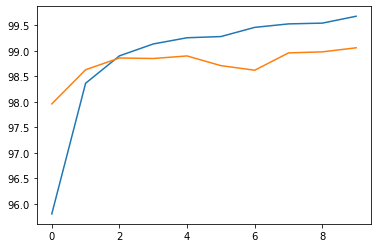

In [ ]:
best_m_cnn = train(num_epochs, learning_rate, device, train_loader, test_loader, None, None)

### part b

In [ ]:
best_m_cnn.to(device)
best_m_cnn.eval()

CNN_Model(
  (cov_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
# standard model on FGSM data
cnn_fgsm_accs = []
cnn_fgsm_examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_test(best_m_cnn, device, test_loader, eps, "fgsm")
    cnn_fgsm_accs.append(acc)
    cnn_fgsm_examples.append(ex)

Epsilon: 0.1	Test Accuracy = 7244 / 10000 = 0.724399983882904
Epsilon: 0.2	Test Accuracy = 3381 / 10000 = 0.33809998631477356
Epsilon: 0.5	Test Accuracy = 1083 / 10000 = 0.10830000042915344


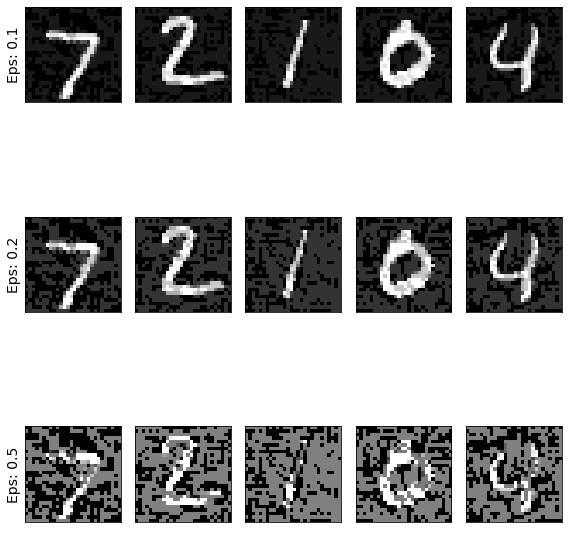

In [ ]:
# FGSM example
plot_samples(epsilons, cnn_fgsm_examples, "cnn_fgsm")

### part c

Epoch:  1 Training Accuracy:  79.461669921875 %
Epoch:  1 Test Accuracy:  97.20999908447266 %
saving best model with accuracy:  97.20999908447266
Epoch:  2 Training Accuracy:  89.32833099365234 %
Epoch:  2 Test Accuracy:  98.44000244140625 %
saving best model with accuracy:  98.44000244140625
Epoch:  3 Training Accuracy:  92.13999938964844 %
Epoch:  3 Test Accuracy:  98.63999938964844 %
saving best model with accuracy:  98.63999938964844
Epoch:  4 Training Accuracy:  93.65499877929688 %
Epoch:  4 Test Accuracy:  98.69000244140625 %
saving best model with accuracy:  98.69000244140625
Epoch:  5 Training Accuracy:  94.38833618164062 %
Epoch:  5 Test Accuracy:  98.66999816894531 %
Epoch:  6 Training Accuracy:  95.00833129882812 %
Epoch:  6 Test Accuracy:  98.69999694824219 %
saving best model with accuracy:  98.69999694824219
Epoch:  7 Training Accuracy:  95.52166748046875 %
Epoch:  7 Test Accuracy:  98.73999786376953 %
saving best model with accuracy:  98.73999786376953
Epoch:  8 Training

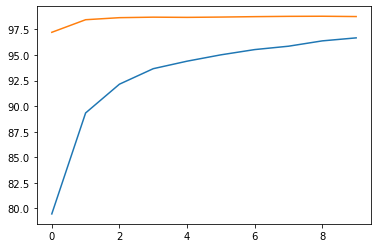

In [ ]:
epsi = 0.2
best_m_fgsm = train(num_epochs, learning_rate, device, train_loader, test_loader, epsi, "fgsm")

In [ ]:
best_m_fgsm.to(device)
best_m_fgsm.eval()

CNN_Model(
  (cov_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
fgsm_fgsm_accs = []
fgsm_fgsm_examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_test(best_m_fgsm, device, test_loader, eps, "fgsm")
    fgsm_fgsm_accs.append(acc)
    fgsm_fgsm_examples.append(ex)

Epsilon: 0.1	Test Accuracy = 9622 / 10000 = 0.9621999859809875
Epsilon: 0.2	Test Accuracy = 9265 / 10000 = 0.9264999628067017
Epsilon: 0.5	Test Accuracy = 2568 / 10000 = 0.25679999589920044


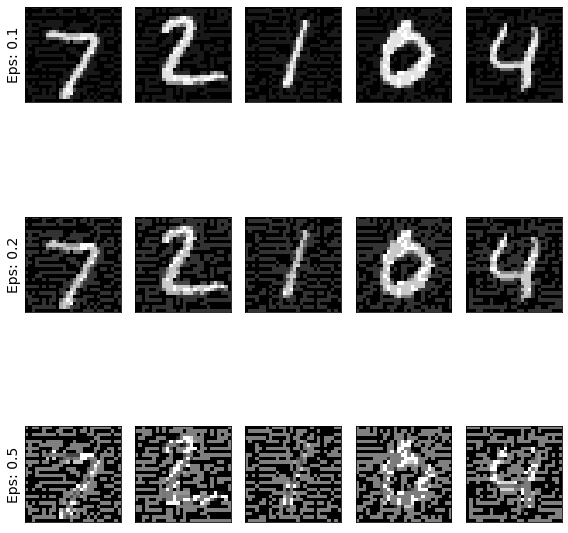

In [ ]:
# FGSM example
plot_samples(epsilons, fgsm_fgsm_examples, "fgsm_fgsm")

### part d

Epoch:  1 Training Accuracy:  72.48833465576172 %
Epoch:  1 Test Accuracy:  96.25 %
saving best model with accuracy:  96.25
Epoch:  2 Training Accuracy:  85.20166778564453 %
Epoch:  2 Test Accuracy:  97.63999938964844 %
saving best model with accuracy:  97.63999938964844
Epoch:  3 Training Accuracy:  88.86499786376953 %
Epoch:  3 Test Accuracy:  98.11000061035156 %
saving best model with accuracy:  98.11000061035156
Epoch:  4 Training Accuracy:  91.36666870117188 %
Epoch:  4 Test Accuracy:  98.31999969482422 %
saving best model with accuracy:  98.31999969482422
Epoch:  5 Training Accuracy:  92.5683364868164 %
Epoch:  5 Test Accuracy:  98.2300033569336 %
Epoch:  6 Training Accuracy:  93.33999633789062 %
Epoch:  6 Test Accuracy:  98.26000213623047 %
Epoch:  7 Training Accuracy:  93.7300033569336 %
Epoch:  7 Test Accuracy:  98.33999633789062 %
saving best model with accuracy:  98.33999633789062
Epoch:  8 Training Accuracy:  94.23833465576172 %
Epoch:  8 Test Accuracy:  98.33000183105469 %

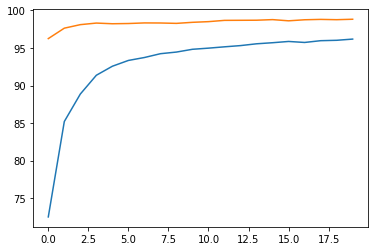

In [ ]:
epsi = 0.2
num_epochs = num_epochs
best_m_pgd = train(20, learning_rate, device, train_loader, test_loader, epsi, "pgd")

In [ ]:
best_m_pgd.to(device)
best_m_pgd.eval()

CNN_Model(
  (cov_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
pgd_fgsm_accs = []
pgd_fgsm_examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_test(best_m_pgd, device, test_loader, eps, "fgsm")
    pgd_fgsm_accs.append(acc)
    pgd_fgsm_examples.append(ex)

Epsilon: 0.1	Test Accuracy = 9726 / 10000 = 0.972599983215332
Epsilon: 0.2	Test Accuracy = 9532 / 10000 = 0.9531999826431274
Epsilon: 0.5	Test Accuracy = 6931 / 10000 = 0.6930999755859375


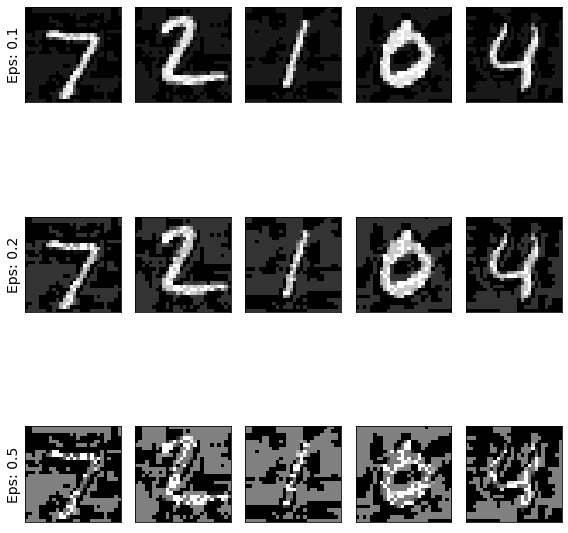

In [ ]:
plot_samples(epsilons, pgd_fgsm_examples, "pgd_fgsm")

In [ ]:
pgd_pgd_accs = []
pgd_pgd_examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_test(best_m_pgd, device, test_loader, eps, "pgd")
    pgd_pgd_accs.append(acc)
    pgd_pgd_examples.append(ex)

Epsilon: 0.1	Test Accuracy = 9690 / 10000 = 0.968999981880188
Epsilon: 0.2	Test Accuracy = 9290 / 10000 = 0.9289999604225159
Epsilon: 0.5	Test Accuracy = 6699 / 10000 = 0.6699000000953674


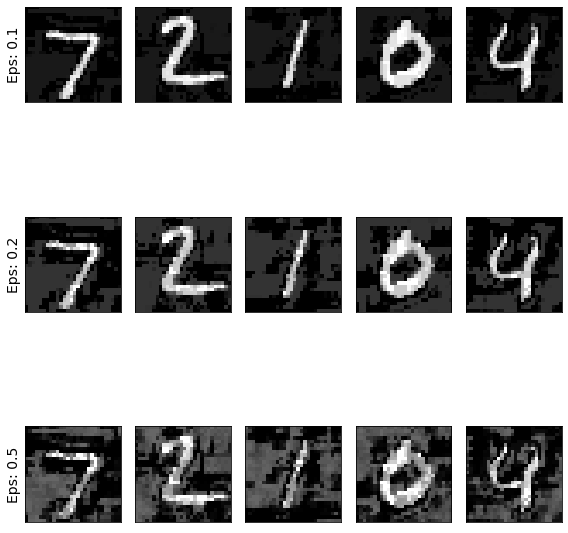

In [ ]:
plot_samples(epsilons, pgd_pgd_examples, "pgd_pgd")

In [ ]:
fgsm_pgd_accs = []
fgsm_pgd_examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_test(best_m_fgsm, device, test_loader, eps, "pgd")
    fgsm_pgd_accs.append(acc)
    fgsm_pgd_examples.append(ex)

Epsilon: 0.1	Test Accuracy = 7925 / 10000 = 0.7924999594688416
Epsilon: 0.2	Test Accuracy = 1429 / 10000 = 0.1428999900817871
Epsilon: 0.5	Test Accuracy = 1 / 10000 = 9.999999747378752e-05


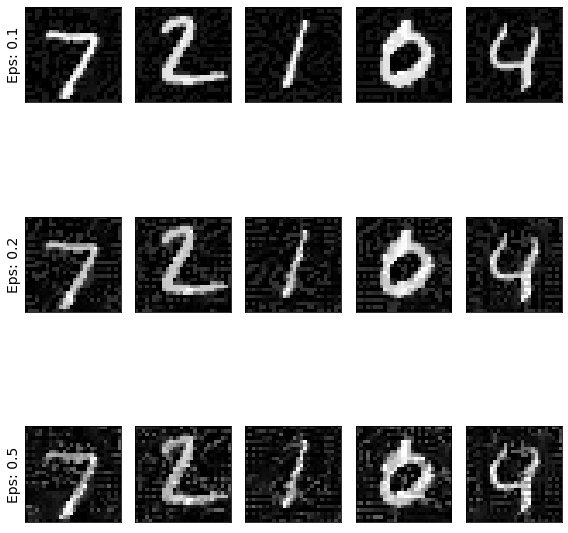

In [ ]:
plot_samples(epsilons, fgsm_pgd_examples, "fgsm_pgd")

In [ ]:
cnn_pgd_accs = []
cnn_pgd_examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_test(best_m_cnn, device, test_loader, eps, "pgd")
    cnn_pgd_accs.append(acc)
    cnn_pgd_examples.append(ex)

Epsilon: 0.1	Test Accuracy = 3350 / 10000 = 0.3349999785423279
Epsilon: 0.2	Test Accuracy = 10 / 10000 = 0.0009999999310821295
Epsilon: 0.5	Test Accuracy = 2 / 10000 = 0.00019999999494757503


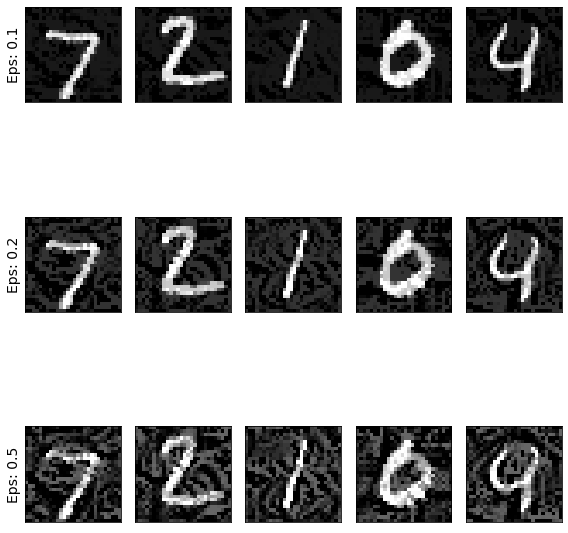

In [ ]:
plot_samples(epsilons, cnn_pgd_examples, "cnn_pgd")